# Exploratory Data Analysis
We'll start by importing packages, reading the data into a dataframe, and checking the datatypes and for nulls. Convenience functions have been written separately so as not to clog up the notebook unnecessarily; see `utils.py` for details.

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import src.utils.eda as eda
import src.utils.helper as helper

In [2]:
raw = pd.read_csv('../data/raw.csv')
raw.head()

,Location,Date,Time,Latitude,Longitude,Altitude,YRMODAHRMI,Month,Hour,Season,Humidity,AmbientTemp,PolyPwr,Wind.Speed,Visibility,Pressure,Cloud.Ceiling
0,Camp Murray,20171203,1145,47.11,-122.57,84,2.017120e+11,12,11,Winter,81.71997,12.86919,2.42769,5,10.0,1010.6,722
1,Camp Murray,20171203,1315,47.11,-122.57,84,2.017120e+11,12,13,Winter,96.64917,9.66415,2.46273,0,10.0,1011.3,23
2,Camp Murray,20171203,1330,47.11,-122.57,84,2.017120e+11,12,13,Winter,93.61572,15.44983,4.46836,5,10.0,1011.6,32
3,Camp Murray,20171204,1230,47.11,-122.57,84,2.017120e+11,12,12,Winter,77.21558,10.36659,1.65364,5,2.0,1024.4,6
4,Camp Murray,20171204,1415,47.11,-122.57,84,2.017120e+11,12,14,Winter,54.80347,16.85471,6.57939,3,3.0,1023.7,9


The following line tidies the various time-related columns and inserts a datatime column for time-series visualisation later on. 

In [4]:
raw = helper.fix_dates(raw)
raw.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21045 entries, 0 to 21044
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Datetime       21045 non-null  datetime64[ns]
 1   Location       21045 non-null  object        
 2   Latitude       21045 non-null  float64       
 3   Longitude      21045 non-null  float64       
 4   Altitude       21045 non-null  int64         
 5   Season         21045 non-null  object        
 6   Humidity       21045 non-null  float64       
 7   AmbientTemp    21045 non-null  float64       
 8   Wind.Speed     21045 non-null  int64         
 9   Visibility     21045 non-null  float64       
 10  Pressure       21045 non-null  float64       
 11  Cloud.Ceiling  21045 non-null  int64         
 12  PolyPwr        21045 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(3), object(2)
memory usage: 2.1+ MB


From above, there are no nulls. However, the data is collected over 499 days from 23 May 2017 to 4 Oct 2018 in 15-minute intervals between 10:00 and 15.45. Assuming an ideal situation of a reading every 15 minutes over this period, we have a ceiling of 6 * 4 * 499 = 11976 possible readings per location and can compare the actual counts with this, as shown below. It's clear that the data collected is quite patchy, with a maximum of 23% of data points present in Travis, which would have to be addressed if we go ahead with time-series modelling later on.

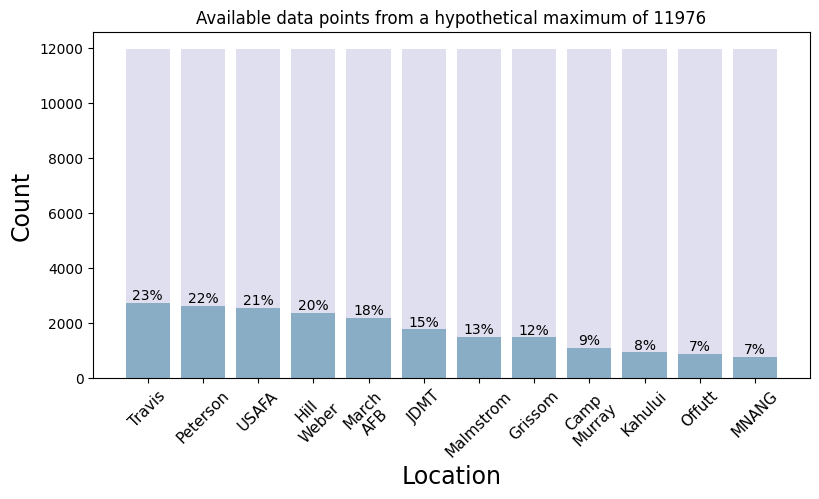

In [5]:
eda.visualise_missing_data(raw)

### Discrepancy between descriptive statistics here and in the paper
Calculating descriptive statistics for the numerical columns, it's noted that the values here differ from those in the paper for some of the features (see `variable units.png`). After investigating, the differences were due to approximately constant scaling factors for each feature, indicating some change of units had taken place. The function `fix_units()` calculates these and transforms the features accordingly. The second set of statistics is then left closely matching those in the paper.

In [6]:
numerical_features = [f for f in raw.columns if f not in ['Datetime', 'Season', 'Latitude', 'Longitude', 'Location']]

raw[numerical_features].describe().round(3).loc[['min', '25%', '50%', 'mean', '75%', 'max']].T

,min,25%,50%,mean,75%,max
Altitude,1.000,2.000,458.000,798.844,1370.000,1947.000
Humidity,0.000,17.529,33.124,37.122,52.594,99.988
AmbientTemp,-19.982,21.915,30.289,29.285,37.475,65.738
Wind.Speed,0.000,6.000,9.000,10.318,14.000,49.000
Visibility,0.000,10.000,10.000,9.700,10.000,10.000
Pressure,781.700,845.500,961.100,925.945,1008.900,1029.500
Cloud.Ceiling,0.000,140.000,722.000,515.967,722.000,722.000
PolyPwr,0.257,6.405,13.799,12.979,18.864,34.285


In [9]:
raw_clean = helper.fix_units(raw)

raw_clean[numerical_features].describe().round(3).loc[['min', '25%', '50%', 'mean', '75%', 'max']].T

,min,25%,50%,mean,75%,max
Altitude,0.303,0.607,138.932,242.325,415.582,590.612
Humidity,0.000,17.529,33.124,37.122,52.594,99.988
AmbientTemp,-19.982,21.915,30.289,29.285,37.475,65.738
Wind.Speed,0.000,9.665,14.497,16.621,22.551,78.929
Visibility,0.000,16.096,16.096,15.614,16.096,16.096
Pressure,781.700,845.500,961.100,925.945,1008.900,1029.500
Cloud.Ceiling,0.000,4.272,22.029,15.743,22.029,22.029
PolyPwr,0.257,6.405,13.799,12.979,18.864,34.285


We note from the above that the numerical features have somewhat different scales (in particular pressure) and so scaling is important if we use a linear model, though this is not relevant for tree-based models. 

### Variable types

In [10]:
raw_clean.dtypes

Datetime         datetime64[ns]
Location                 object
Latitude                float64
Longitude               float64
Altitude                float64
Season                   object
Humidity                float64
AmbientTemp             float64
Wind.Speed              float64
Visibility              float64
Pressure                float64
Cloud.Ceiling           float64
PolyPwr                 float64
dtype: object

We have a mix of categorical, numerical and datetime data types. As there aren't too many, we can briefly examine each column's values.

In [11]:
for col in raw_clean.columns:
    print(col, raw_clean[col].unique().tolist()[:10], '\n')

Datetime [Timestamp('2017-12-03 11:45:00'), Timestamp('2017-12-03 13:15:00'), Timestamp('2017-12-03 13:30:00'), Timestamp('2017-12-04 12:30:00'), Timestamp('2017-12-04 14:15:00'), Timestamp('2017-12-04 14:30:00'), Timestamp('2017-12-05 11:15:00'), Timestamp('2017-12-05 12:00:00'), Timestamp('2017-12-05 13:00:00'), Timestamp('2017-12-05 14:00:00')] 

Location ['Camp Murray', 'Grissom', 'Hill Weber', 'JDMT', 'Kahului', 'Malmstrom', 'March AFB', 'MNANG', 'Offutt', 'Peterson'] 

Latitude [47.11, 40.67, 41.15, 26.98, 20.89, 47.52, 33.9, 44.89, 41.13, 38.82] 

Longitude [-122.57, -86.15, -111.99, -80.11, -156.44, -111.18, -117.26, -93.2, -95.75, -104.71] 

Altitude [25.480964821029243, 72.49941181221416, 415.58240243821507, 0.6066896385959344, 316.38864652777977, 138.93192723846897, 74.62282554729993, 115.27103133322754, 569.9849154608803, 0.3033448192979672] 

Season ['Winter', 'Spring', 'Summer', 'Fall'] 

Humidity [81.71997, 96.64917, 93.61572, 77.21558, 54.80347, 47.10083, 43.55469, 30.5

We can separate these out into particular types immediately. Note that altitude, latitude and longitude appear to take continuous values but actually are constant for each of the twelve locations, so these will be treated as discrete. 

In [12]:
datetime = ['Datetime']

discrete = [col for col in raw.columns if raw_clean[col].dtype not in ['O', '<M8[ns]'] 
            and col != 'PolyPwr' and raw_clean[col].nunique() <= 20]

continuous = [col for col in raw.columns if raw_clean[col].dtype not in ['O', '<M8[ns]'] 
              and col != 'PolyPwr' and col not in discrete]

categorical = [col for col in raw.columns if raw_clean[col].dtype == 'O']

In [13]:
datetime, discrete, continuous, categorical

(['Datetime'],
 ['Latitude', 'Longitude', 'Altitude'],
 ['Humidity',
  'AmbientTemp',
  'Wind.Speed',
  'Visibility',
  'Pressure',
  'Cloud.Ceiling'],
 ['Location', 'Season'])

### Mutual Information Scores
Mutual information gives us an indication of how informative a give feature is in relation to the target. 

In [14]:
eda.make_mi_scores(inputs=raw_clean.drop(columns=['Datetime', 'PolyPwr'], axis=1), target=raw_clean['PolyPwr'])

Longitude        0.301899
Latitude         0.301706
Location         0.299519
AmbientTemp      0.296636
Altitude         0.278292
Pressure         0.201640
Cloud.Ceiling    0.164115
Humidity         0.161527
Season           0.156391
Visibility       0.032770
Wind.Speed       0.014201
Name: MI Scores, dtype: float64

### Variable characteristics

We saw above that there are no nulls in the dataset, so we don't need to worry about imputation here. We can check whether we have any rare labels by plotting the percentage of readings for each label. The red line indicates labels that appear in less than 5% of the readings, and as such could be considered rare; we highlight the Kahului, Offutt, MNANG and perhaps Camp Murray locations that may benefit from grouping into a single 'rare' category. Note that the categorical features have twelve and four labels, so we also don't have to worry about highly cardinal features. 

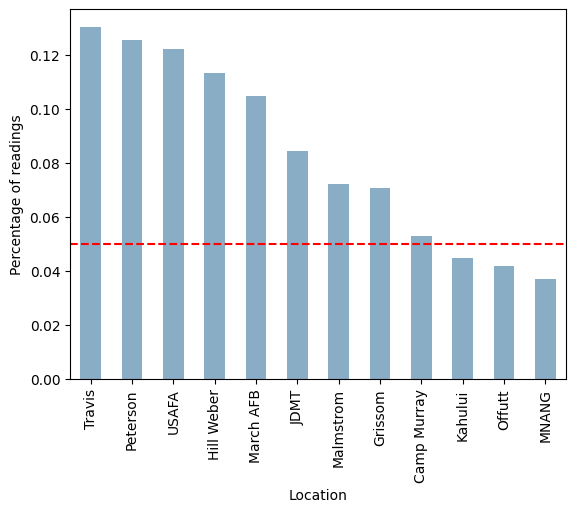

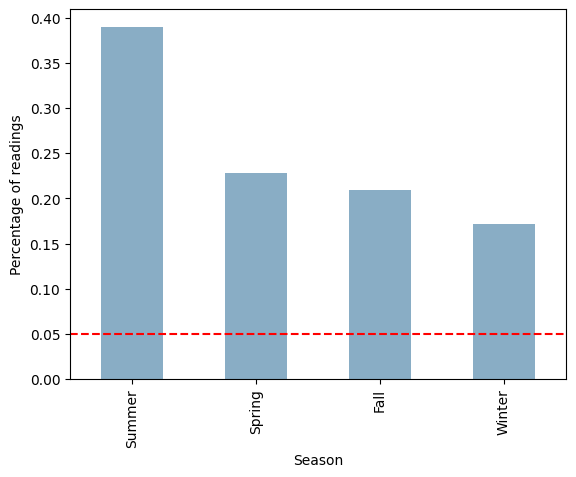

In [16]:
for col in categorical:    
    eda.plot_percentages_by_label(raw_clean, col)

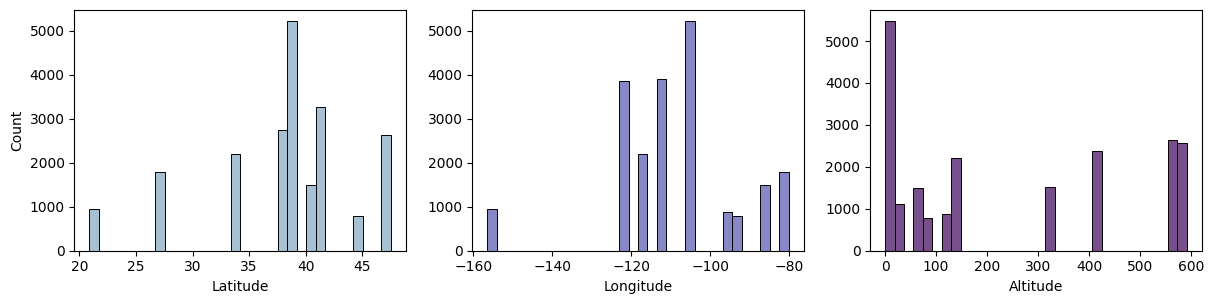

In [17]:
eda.numerical_distributions(raw_clean, discrete)

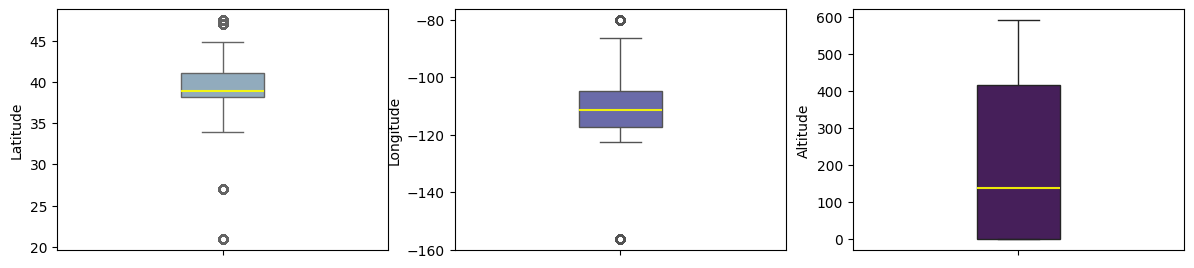

In [18]:
eda.numerical_distributions(raw_clean, discrete, plot_type='box')

We can ignore the outliers in the latitude and longitude for the moment since they are special cases. 

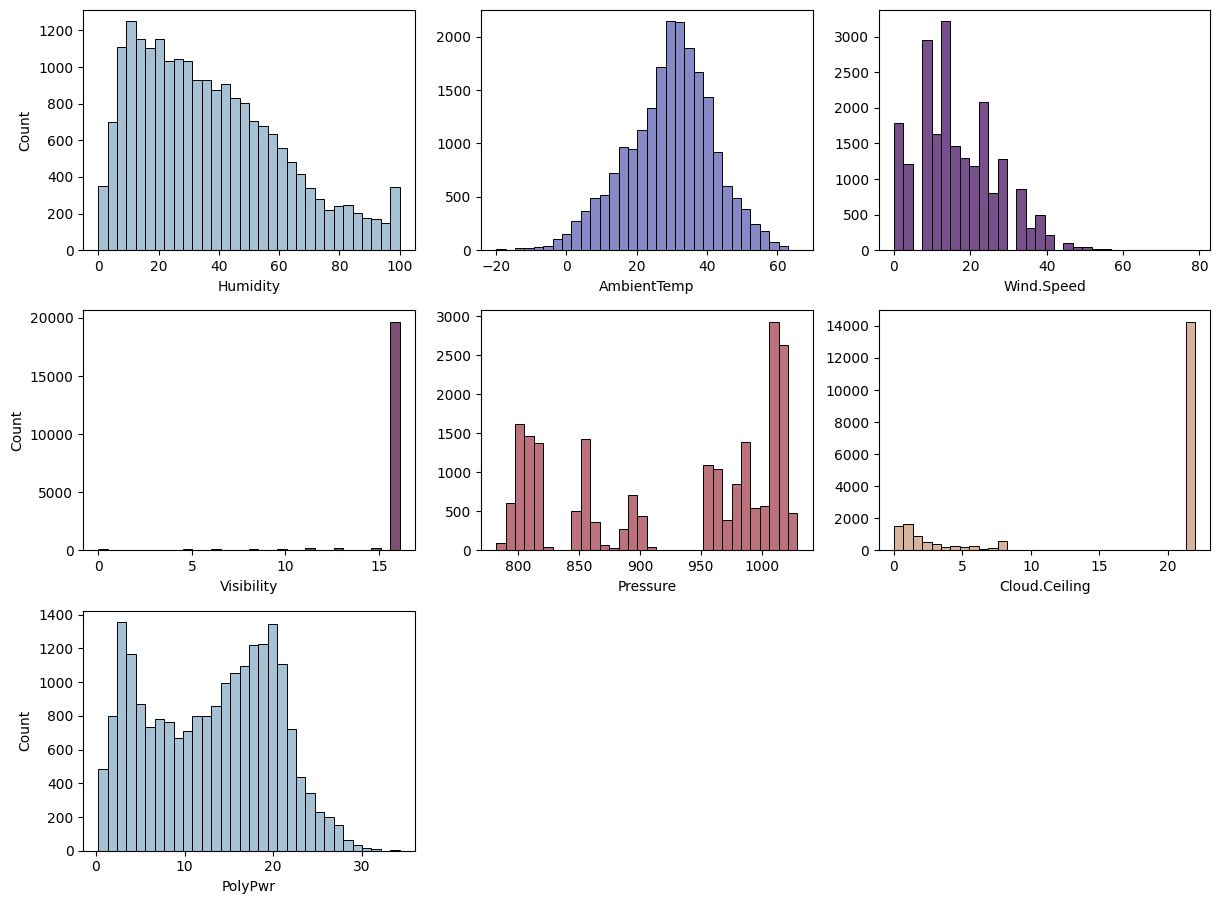

In [19]:
eda.numerical_distributions(raw_clean, continuous + ["PolyPwr"])

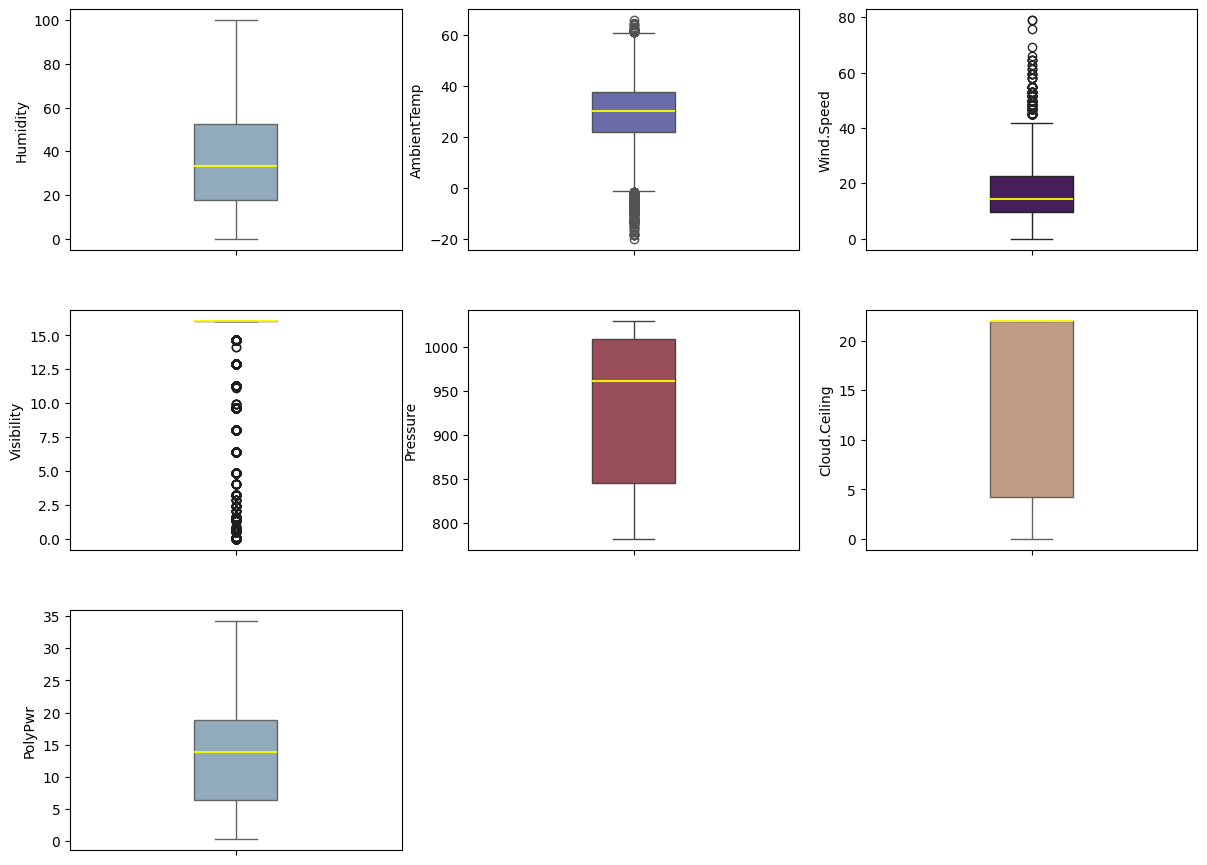

In [20]:
eda.numerical_distributions(raw_clean, continuous + ["PolyPwr"], plot_type='box')

We have outliers in temperatures, wind speed and visibility. The latter also appears to have a highly skewed distribution with the 93% of points taking a single value, and we see something similar, though less extreme, with the cloud ceiling, where some 70% of the data points are represented by only four values. Both of these features may benefit from discretization whereas the outliers are less of a problem for a tree-based model but would have to be treated if using a linear model. 

In [21]:
raw_clean['Visibility'].value_counts(normalize=True).iloc[:10]

Visibility
16.096495    0.934569
14.647810    0.010976
11.267546    0.009171
12.877196    0.008411
9.657897     0.006938
8.048247     0.005845
6.438598     0.005274
4.828948     0.004514
0.000000     0.003231
3.219299     0.002946
Name: proportion, dtype: float64

In [22]:
raw_clean['Cloud.Ceiling'].value_counts(normalize=True).iloc[:10]

Cloud.Ceiling
22.028990    0.677406
7.627767     0.027940
6.102213     0.010739
1.830664     0.010216
1.525553     0.009123
1.678109     0.008838
3.051107     0.007983
3.356217     0.007128
4.576660     0.006510
2.135775     0.006272
Name: proportion, dtype: float64

We'll now check the variation of average power with time of day and month of the year. The shaded areas indicate a value of +/- one standard deviation from the mean and the results are unsurprising. We see an increase in output from the morning towards the middle of the day, where the sun is higher in the sky, before tailing off towards the afternoon; similarly, average power peaks near June and July, when it is summer in the Northern Hemisphere. These could be encoded cyclically or using radial basis functions to represent that, e.g., points for Dec and Jan are close to one another. 

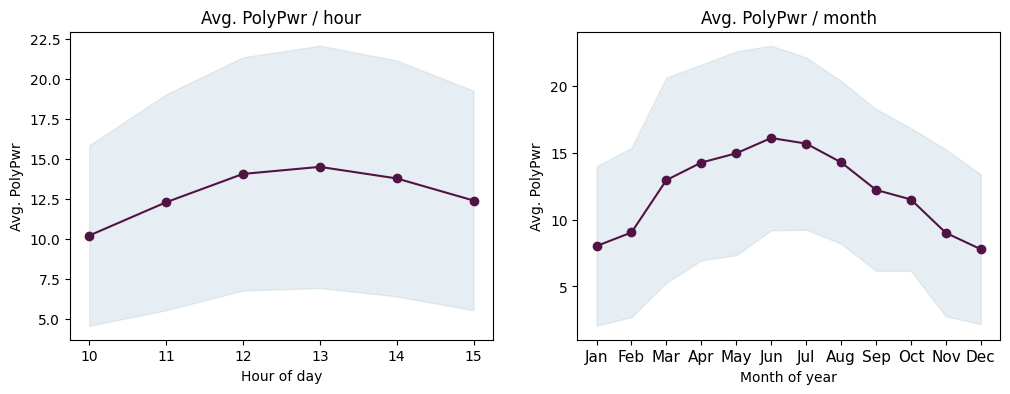

In [23]:
eda.plot_power_against_time(raw_clean)

Looking at the variation of power output by location, we see that while there doesn't seem to be a huge amount of variation by hour of day, there appears to be much more variation when we look at the monthly change. 

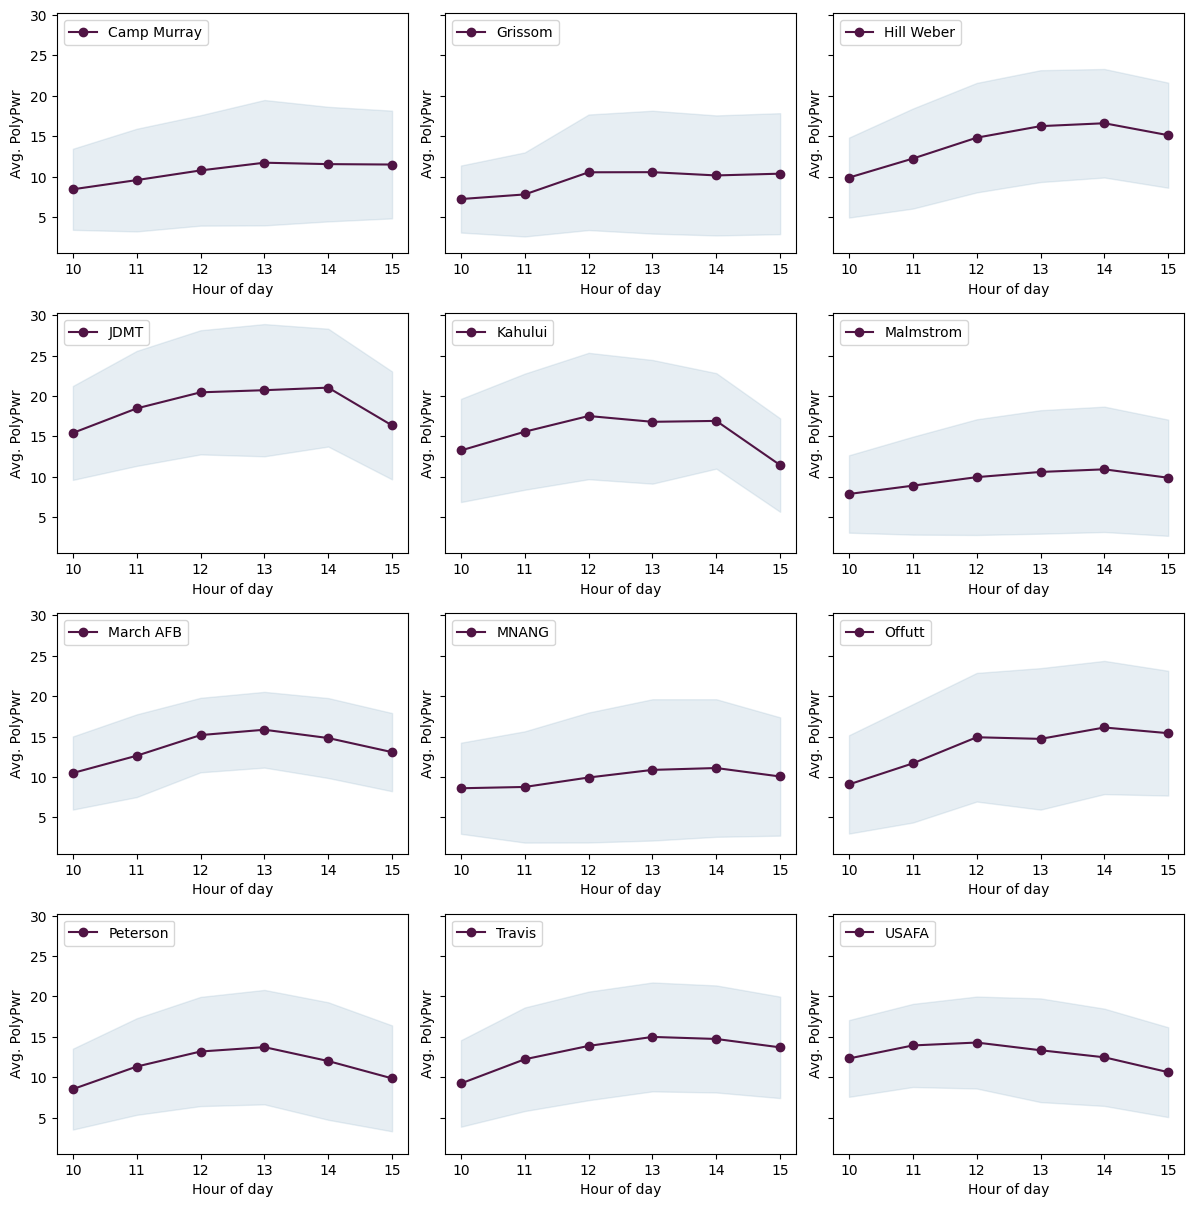

In [24]:
eda.plot_grouped_power_against_time(raw_clean, cat_col='Location', time_increment='hour_of_day')

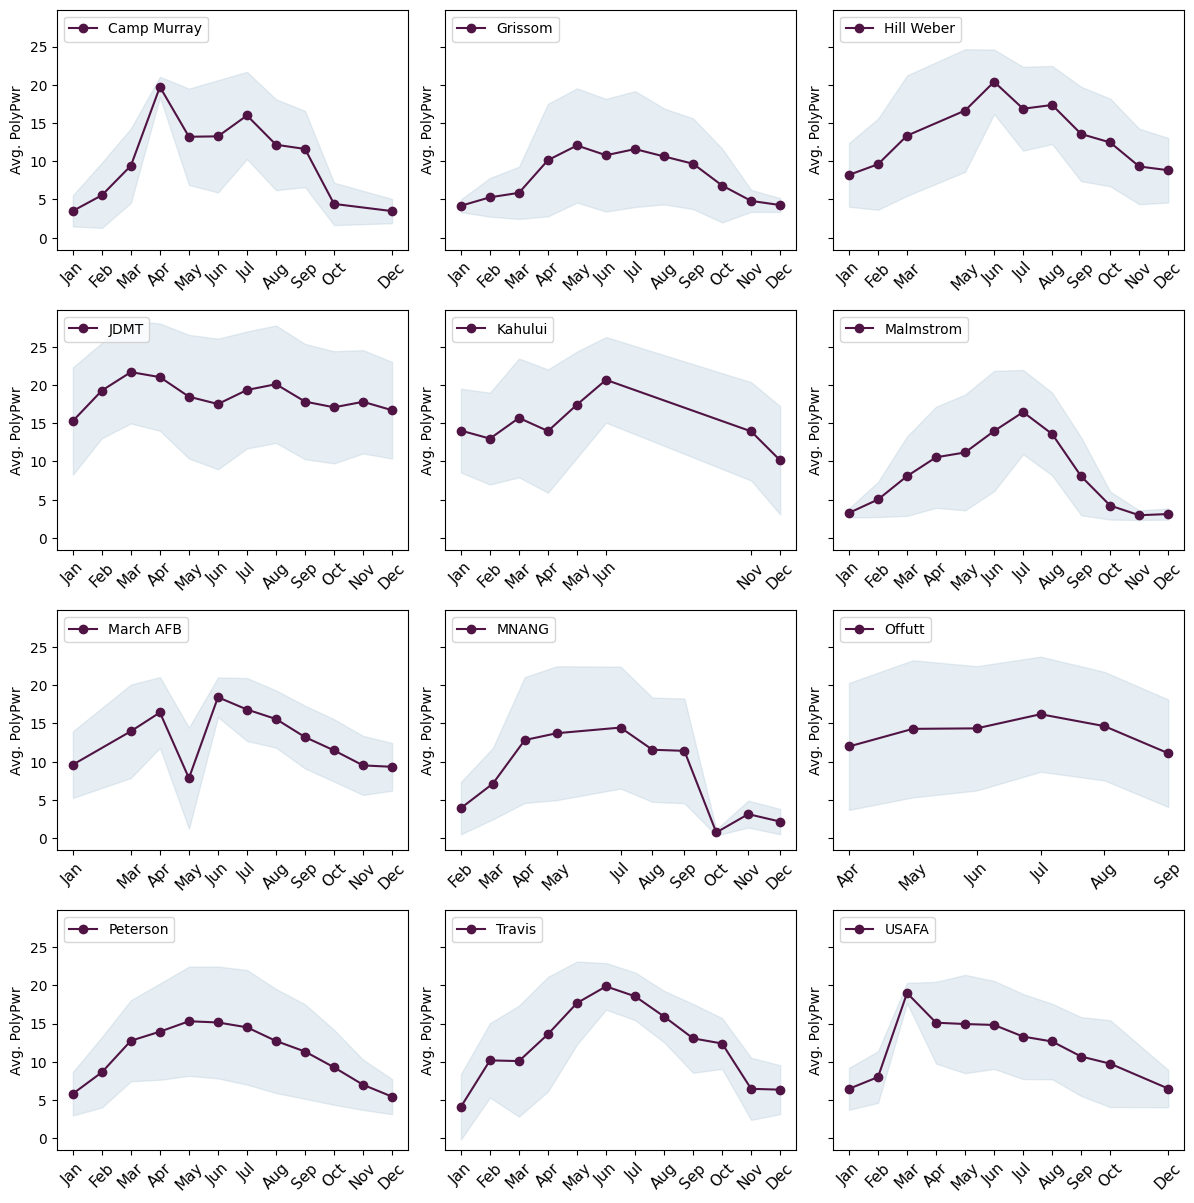

In [25]:
eda.plot_grouped_power_against_time(raw_clean, cat_col='Location', time_increment='month_of_year')

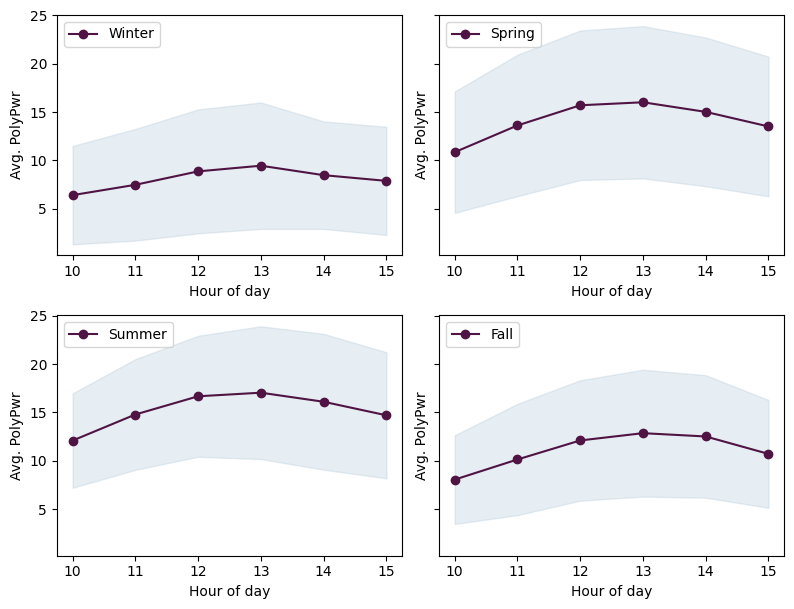

In [26]:
eda.plot_grouped_power_against_time(raw_clean, cat_col='Season', time_increment='hour_of_day')

We can check for the Pearson correlation values between the continuous features and the target, which measures the strength of the linear relationships assuming normality. This isn't necessarily that informative since we saw from above that most features have non-gaussian distributions and the target looks bimodel, but can still help to flag strong relationships between features that would have to be dealt with. In this case, temperature appears to have the strongest relationship with the power. Temperature and humidity are correlated with one another while neither wind speed or pressure appear to have a strong relationship with the target. 

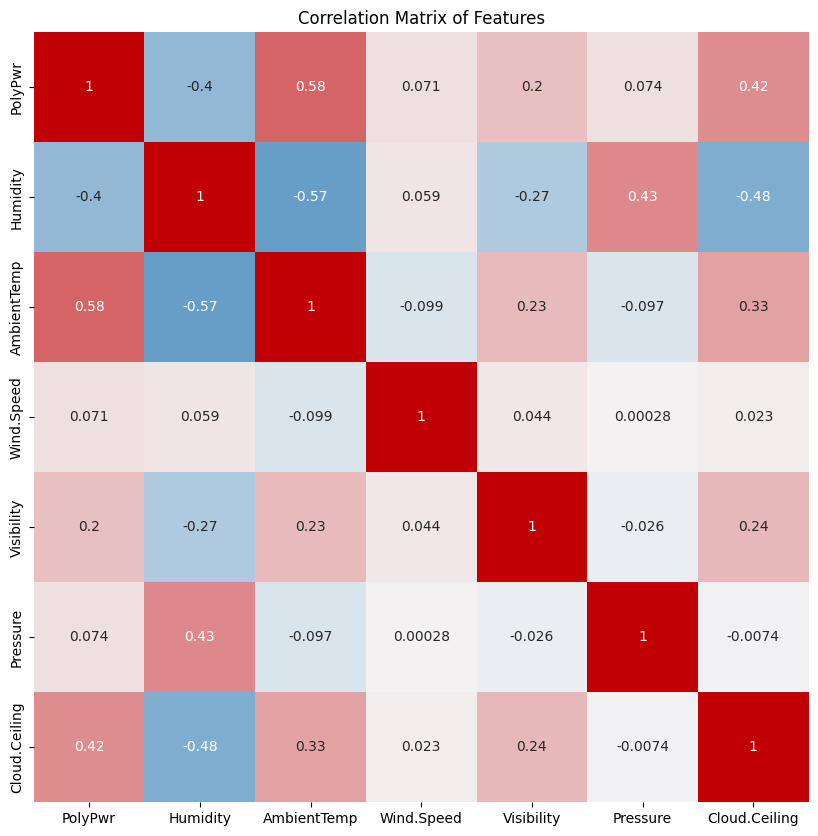

In [27]:
eda.correlation_matrix(raw_clean[["PolyPwr"] + continuous])